<a href="https://colab.research.google.com/github/NBK-code/Intel_Image_Classification/blob/main/Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Import Necessary Libraries


In [26]:
import pathlib
import cv2
import numpy as np
import matplotlib.pylab as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sn

##2. Download Intel Dataset

In [ ]:
from zipfile import ZipFile
file_name = 'Intel.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done!')

Done!


##3. Construct Train and Test Data

In [ ]:
data_dir_train = pathlib.Path('/content/seg_train/seg_train')
data_dir_test = pathlib.Path('/content/seg_test/seg_test')
data_dir_pred = pathlib.Path('/content/seg_pred')

In [ ]:
print('The number of train images:', len(list(data_dir_train.glob('*/*.jpg'))))
print('The number of test images:', len(list(data_dir_test.glob('*/*.jpg'))))
print('The number of pred images:', len(list(data_dir_pred.glob('*/*.jpg'))))

The number of train images: 14034
The number of test images: 3000
The number of pred images: 7301


In [ ]:
Intel_train_images_dict = {
    'buildings': list(data_dir_train.glob('buildings/*')),
    'forest': list(data_dir_train.glob('forest/*')),
    'glacier': list(data_dir_train.glob('glacier/*')),
    'mountain': list(data_dir_train.glob('mountain/*')),
    'sea': list(data_dir_train.glob('sea/*')),
    'street': list(data_dir_train.glob('street/*'))
}

In [ ]:
Intel_train_images_len_dict = {
    'buildings': len(list(data_dir_train.glob('buildings/*'))),
    'forest': len(list(data_dir_train.glob('forest/*'))),
    'glacier': len(list(data_dir_train.glob('glacier/*'))),
    'mountain': len(list(data_dir_train.glob('mountain/*'))),
    'sea': len(list(data_dir_train.glob('sea/*'))),
    'street': len(list(data_dir_train.glob('street/*')))
}

Intel_train_images_len_dict

{'buildings': 2191,
 'forest': 2271,
 'glacier': 2404,
 'mountain': 2512,
 'sea': 2274,
 'street': 2382}

It is a balanced dataset.

In [ ]:
Intel_test_images_dict = {
    'buildings': list(data_dir_test.glob('buildings/*')),
    'forest': list(data_dir_test.glob('forest/*')),
    'glacier': list(data_dir_test.glob('glacier/*')),
    'mountain': list(data_dir_test.glob('mountain/*')),
    'sea': list(data_dir_test.glob('sea/*')),
    'street': list(data_dir_test.glob('street/*'))
}

In [ ]:
Intel_labels_dict = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}

In [ ]:
X_train, y_train = [], []

for category, images in Intel_train_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(128,128))
        X_train.append(resized_img)
        y_train.append(Intel_labels_dict[category])

In [ ]:
X_test, y_test = [], []

for category, images in Intel_test_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(128,128))
        X_test.append(resized_img)
        y_test.append(Intel_labels_dict[category])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=0)

In [ ]:
X_train_scaled = np.array(X_train) / 255.0
X_val_scaled = np.array(X_val) / 255.0
X_test_scaled = np.array(X_test) / 255.0

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
print('Shape of X_train_scaled:', X_train_scaled.shape)
print('Shape of X_val_scaled:', X_val_scaled.shape)
print('Shape of X_test_scaled:', X_test_scaled.shape)

Shape of X_train_scaled: (11227, 128, 128, 3)
Shape of X_val_scaled: (2807, 128, 128, 3)
Shape of X_test_scaled: (3000, 128, 128, 3)


##4. VGG 16

###4.1. Build Model

In [ ]:
vgg16 = VGG16(input_shape = (128,128,3) , weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
for layer in vgg16.layers:
    layer.trainable = False

In [ ]:
h1 = Flatten()(vgg16.output)
h2 = Dense(200, activation = 'relu')(h1)
h3 = Dropout(0.2)(h2)
h4 = Dense(200, activation = 'relu')(h3)
prediction = Dense(6, activation='softmax')(h4)

model = Model(inputs=vgg16.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [ ]:
cp = ModelCheckpoint('models/VGG_transfer_learning', save_best_only=True)
r = model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_val_scaled, y_val), callbacks = [cp])

Epoch 1/10
351/351 [==============================] - 16s 43ms/step - loss: 0.4506 - accuracy: 0.8350 - val_loss: 0.3285 - val_accuracy: 0.8849
Epoch 2/10
351/351 [==============================] - 14s 40ms/step - loss: 0.2932 - accuracy: 0.8927 - val_loss: 0.3181 - val_accuracy: 0.8921
Epoch 3/10
351/351 [==============================] - 12s 34ms/step - loss: 0.2243 - accuracy: 0.9165 - val_loss: 0.3566 - val_accuracy: 0.8782
Epoch 4/10
351/351 [==============================] - 12s 35ms/step - loss: 0.1817 - accuracy: 0.9338 - val_loss: 0.3551 - val_accuracy: 0.8871
Epoch 5/10
351/351 [==============================] - 12s 35ms/step - loss: 0.1575 - accuracy: 0.9403 - val_loss: 0.3725 - val_accuracy: 0.8782
Epoch 6/10
351/351 [==============================] - 12s 35ms/step - loss: 0.1240 - accuracy: 0.9534 - val_loss: 0.3990 - val_accuracy: 0.8871
Epoch 7/10
351/351 [==============================] - 12s 35ms/step - loss: 0.1039 - accuracy: 0.9623 - val_loss: 0.3883 - val_accuracy:

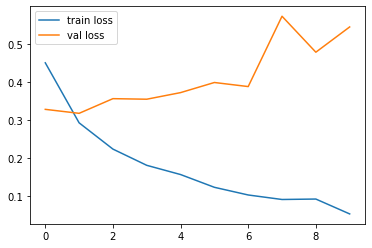

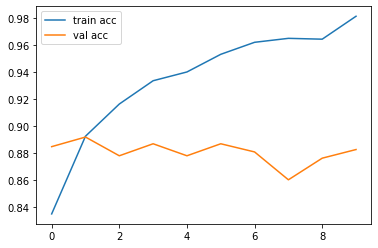

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

###4.2. Model Predictions

In [ ]:
model = load_model('models/VGG_transfer_learning')

In [ ]:
model.evaluate(X_test_scaled,y_test)

94/94 [==============================] - 3s 28ms/step - loss: 0.3206 - accuracy: 0.8833


[0.32061564922332764, 0.8833333253860474]

In [ ]:
test_predictions = model.predict(X_test_scaled)  
test_pred_labels = np.argmax(test_predictions, axis = 1)

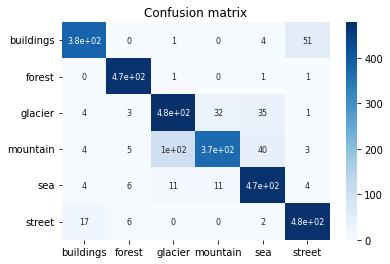

In [ ]:
CM = confusion_matrix(y_test, test_pred_labels)
ax = plt.axes()
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 8}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax, cmap='Blues')
ax.set_title('Confusion matrix')
plt.show()

##5. Inception v3

###5.1. Build Model

In [ ]:
inceptionv3 = InceptionV3(input_shape = (128,128,3) , weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in inceptionv3.layers:
    layer.trainable = False

In [27]:
h1 = Flatten()(inceptionv3.output)
h2 = Dense(200, activation = 'relu')(h1)
h3 = Dropout(0.2)(h2)
h4 = Dense(200, activation = 'relu')(h3)
prediction = Dense(6, activation='softmax')(h4)

model = Model(inputs=inceptionv3.input, outputs=prediction)

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [29]:
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [30]:
cp = ModelCheckpoint('models/inceptionv3_transfer_learning', save_best_only=True)
r = model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_val_scaled, y_val), callbacks = [cp])

Epoch 1/10
351/351 [==============================] - 44s 114ms/step - loss: 0.7301 - accuracy: 0.7450 - val_loss: 0.5339 - val_accuracy: 0.8147
Epoch 2/10
351/351 [==============================] - 38s 108ms/step - loss: 0.5142 - accuracy: 0.8083 - val_loss: 0.5119 - val_accuracy: 0.8169
Epoch 3/10
351/351 [==============================] - 38s 108ms/step - loss: 0.4454 - accuracy: 0.8350 - val_loss: 0.4904 - val_accuracy: 0.8279
Epoch 4/10
351/351 [==============================] - 38s 108ms/step - loss: 0.4049 - accuracy: 0.8478 - val_loss: 0.4754 - val_accuracy: 0.8365
Epoch 5/10
351/351 [==============================] - 38s 108ms/step - loss: 0.3649 - accuracy: 0.8643 - val_loss: 0.4492 - val_accuracy: 0.8561
Epoch 6/10
351/351 [==============================] - 13s 38ms/step - loss: 0.3506 - accuracy: 0.8677 - val_loss: 0.4868 - val_accuracy: 0.8400
Epoch 7/10
351/351 [==============================] - 13s 38ms/step - loss: 0.3144 - accuracy: 0.8811 - val_loss: 0.4712 - val_accu

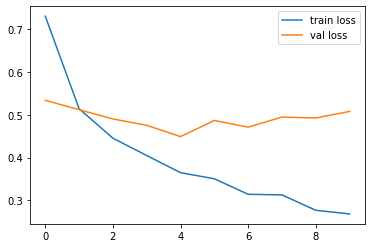

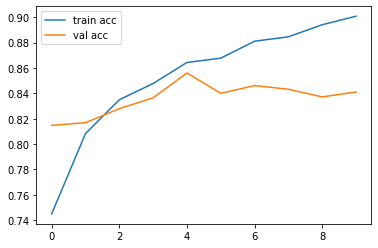

<Figure size 432x288 with 0 Axes>

In [31]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

###5.2. Model Predictions

In [32]:
model = load_model('models/inceptionv3_transfer_learning')

In [33]:
model.evaluate(X_test_scaled,y_test)

94/94 [==============================] - 4s 32ms/step - loss: 0.4426 - accuracy: 0.8420


[0.44255924224853516, 0.8420000076293945]

In [34]:
test_predictions = model.predict(X_test_scaled)  
test_pred_labels = np.argmax(test_predictions, axis = 1)

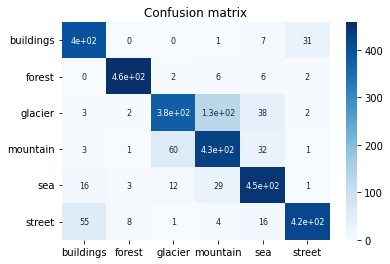

In [35]:
CM = confusion_matrix(y_test, test_pred_labels)
ax = plt.axes()
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 8}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax, cmap='Blues')
ax.set_title('Confusion matrix')
plt.show()